## Import packages

In [1]:
library(devtools)
# library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
# library(quantmod)
# library(xts)
# library(zoo)
library(gridExtra)
# library(tibble)
library(grid)
# library(future)
# library(future.apply)
# library(DescTools)
# library(rcompanion)
# library(tidyverse)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
source("forecast_research/finance/markets_functions.R")


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [3]:
load_all("forecast_research/vendor/hmmTMB")

ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB



In [4]:
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB")

Skipping install of 'hmmTMB' from a local remote, the SHA1 (1.1.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [5]:
options(warn = -1)

## Import close data

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_Care_Index, Shipping_Futures



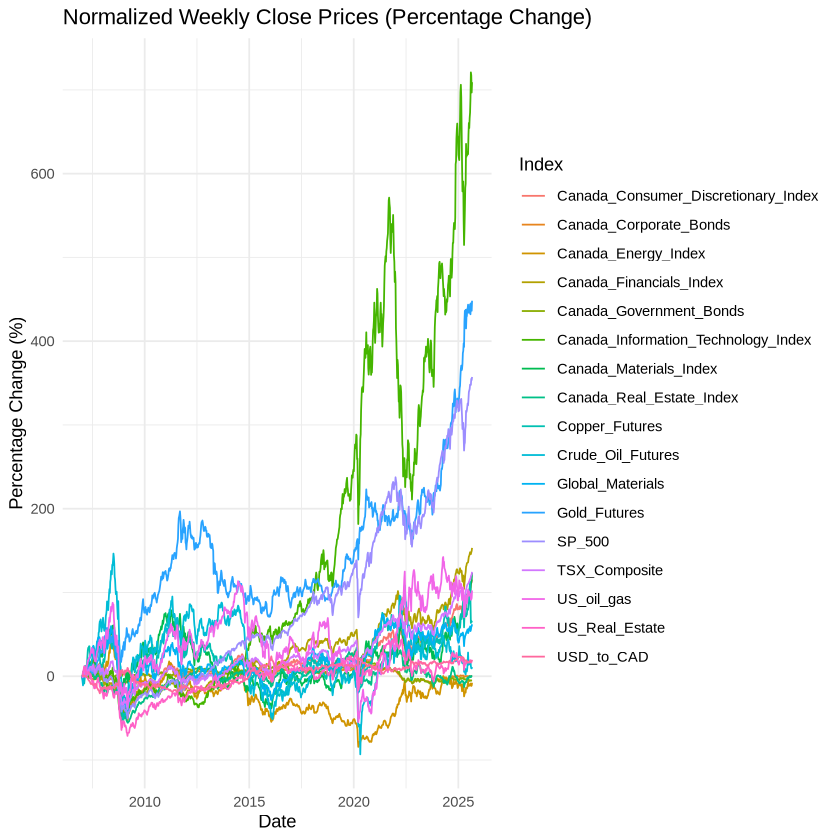

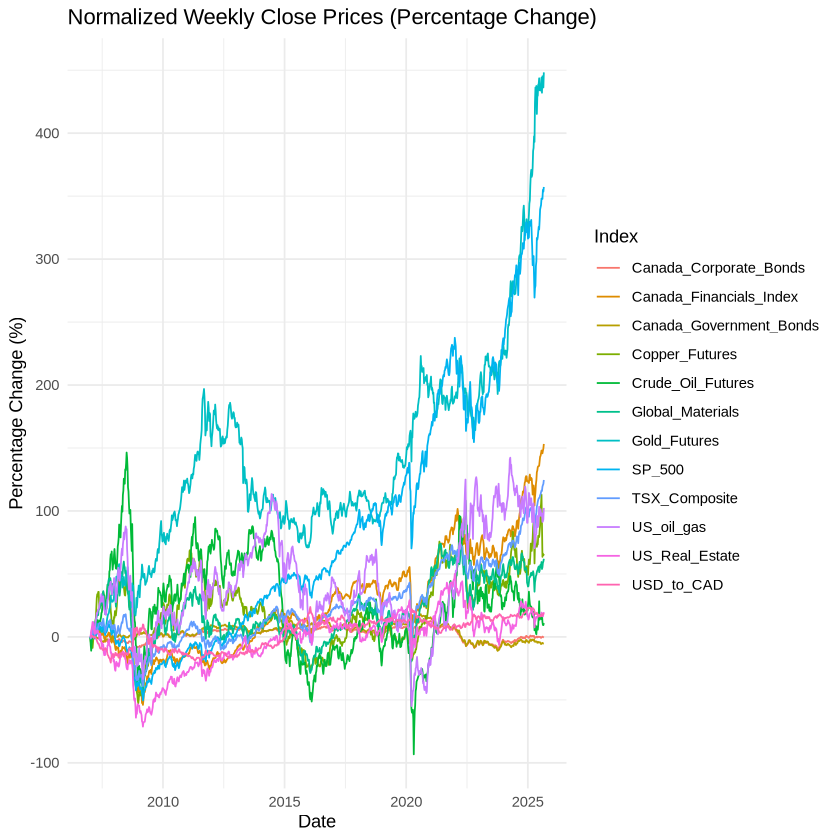

In [6]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )

close_data_log <- ln_transform(close_data)

# Reshape data for ggplot
close_data_long <- close_data %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100)

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

In [7]:
# Fit HMM with covariates on train
evaluate_model <- function(train, test, formula) {
  combined   <- rbind(train, test)
  train_size <- nrow(train)
  test_size  <- nrow(test)
  
  hmm <- fit_hmm(
    data        = train,
    obs_name    = obs_name,
    n_states    = n_states,
    hid_formula = formula,
    horseshoe   = FALSE
  )
  forecast <- Forecast$new(
    hmm                        = hmm,
    forecast_data              = test,
    starting_state_distribution = "last",
    preset_eval_range          = setNames(list(eval_range), obs_name)
  )
  true_model <- fit_hmm(
    data        = combined,
    obs_name    = obs_name,
    n_states    = n_states,
    hid_formula = formula,
    horseshoe   = FALSE,
    init        = hmm
  )

  # -- State forecast log-loss --
  forecast_states <- matrix(
    forecast$hidden_state_forecast(),
    ncol = n_states,
    byrow = TRUE
  )
  true_states <- tail(true_model$state_probs(), test_size)
  
  state_cross_entropy <- as.matrix(
    -rowSums(true_states * log(forecast_states + 1e-10))
    , nrow = test_size, ncol = -1
  )

  # --- Prediction log-loss ---
  forecast_dists <- forecast$forecast_dists()[[obs_name]]
  eval_range_loc <- forecast$eval_range()[[obs_name]]

  prediction_loss <- numeric(test_size)
  for (j in seq_len(test_size)) {
    pdf_val <- tryCatch(
      {
        val <- approx(
          x    = eval_range_loc,
          y    = forecast_dists[, j],
          xout = test[[obs_name]][j]
        )$y
      },
      error = function(e) NaN
    )
    prediction_loss[j] <- -log(pdf_val)
  }

  list(
    state_forecast     = forecast_states,
    true_states        = true_states,
    state_logloss      = state_cross_entropy,
    prediction_logloss = prediction_loss,
    hmm                = true_model,
    forecast           = forecast
  )
}

In [8]:
compute_cov_loss <- function(samples, obs_name, cov_name, n_states, eval_range, max_test_size) {
  # Number of time series samples
  n_series   <- length(samples$train)

  series     <- vector("list", n_series)

  train_size <- nrow(samples$train[[1]])
  test_size  <- nrow(samples$test[[1]])

  for (i in seq_len(n_series)) {
    train_sample <- samples$train[[i]]
    test_sample  <- samples$test[[i]]

    # 1) Fit HMM on the covariate alone
    if (!is.null(cov_name)) {
      covariate <- fit_hmm(
        data        = train_sample,
        obs_name    = cov_name,
        n_states    = n_states,
        hid_formula = ~ 1,
        horseshoe   = FALSE
      )

      cov_states <- covariate$state_probs()
      colnames(cov_states) <- paste0(cov_name, "_State_", seq_len(n_states))

      # Formula: obs ~ 1 + cov_name_State_1 + ... + cov_name_State_K
      formula <- as.formula(
        paste0(" ~ 1 + ", paste(colnames(cov_states), collapse = " + "))
      )
    } else {
      cov_states <- matrix(NA, nrow = train_size, ncol = 1)
      formula <- as.formula(" ~ 1")
    }

    # 2) Lag covariate states by test_size
    lagged_cov <- rbind(
      matrix(NA, nrow = test_size, ncol = ncol(cov_states)),
      cov_states
    )

    # Create full combined data with
    combined <- data.frame(
      obs = rbind(train_sample, test_sample)[[obs_name]],
      lagged_cov,
      check.names = FALSE
    )
    names(combined)[1] <- obs_name  # rename "obs" column to obs_name

    train <- combined[(max_test_size + 1):train_size, , drop = FALSE]
    test  <- combined[(train_size + 1):(train_size + test_size), , drop = FALSE]

    series[[i]] <- list(
      cov_model = evaluate_model(train, test, formula),
      tsx_model = evaluate_model(train, test, ~ 1)
    )
  }
  series
}


In [9]:
train_cutoff <- as.Date("2020-01-01")
train_size <- which.min(abs(close_data$Date - train_cutoff))
max_test_size <- 20
n_samples <- 25
n_states <- 3
eval_range <- seq(from = -0.2, to = 0.2, by = 0.001)
obs_name <- "TSX_Composite"
cov_name <- "Gold_Futures"
log_data <- ln_transform(close_data)

In [10]:
library(parallel)

n_cores    <- as.integer(Sys.getenv("SLURM_CPUS_PER_TASK", "1"))
test_sizes <- seq_len(max_test_size)

rm(results)

parallel_fun <- function(test_size) {
  samples <- train_test_split(
    log_data,
    training_period = train_size,
    testing_period  = test_size,
    samples         = n_samples,
    max_test_size   = max_test_size
  )
  compute_cov_loss(samples, obs_name, cov_name, n_states, eval_range, max_test_size)
}

results <- mclapply(
  test_sizes,
  parallel_fun,
  mc.cores    = n_cores,
  mc.set.seed = TRUE
)

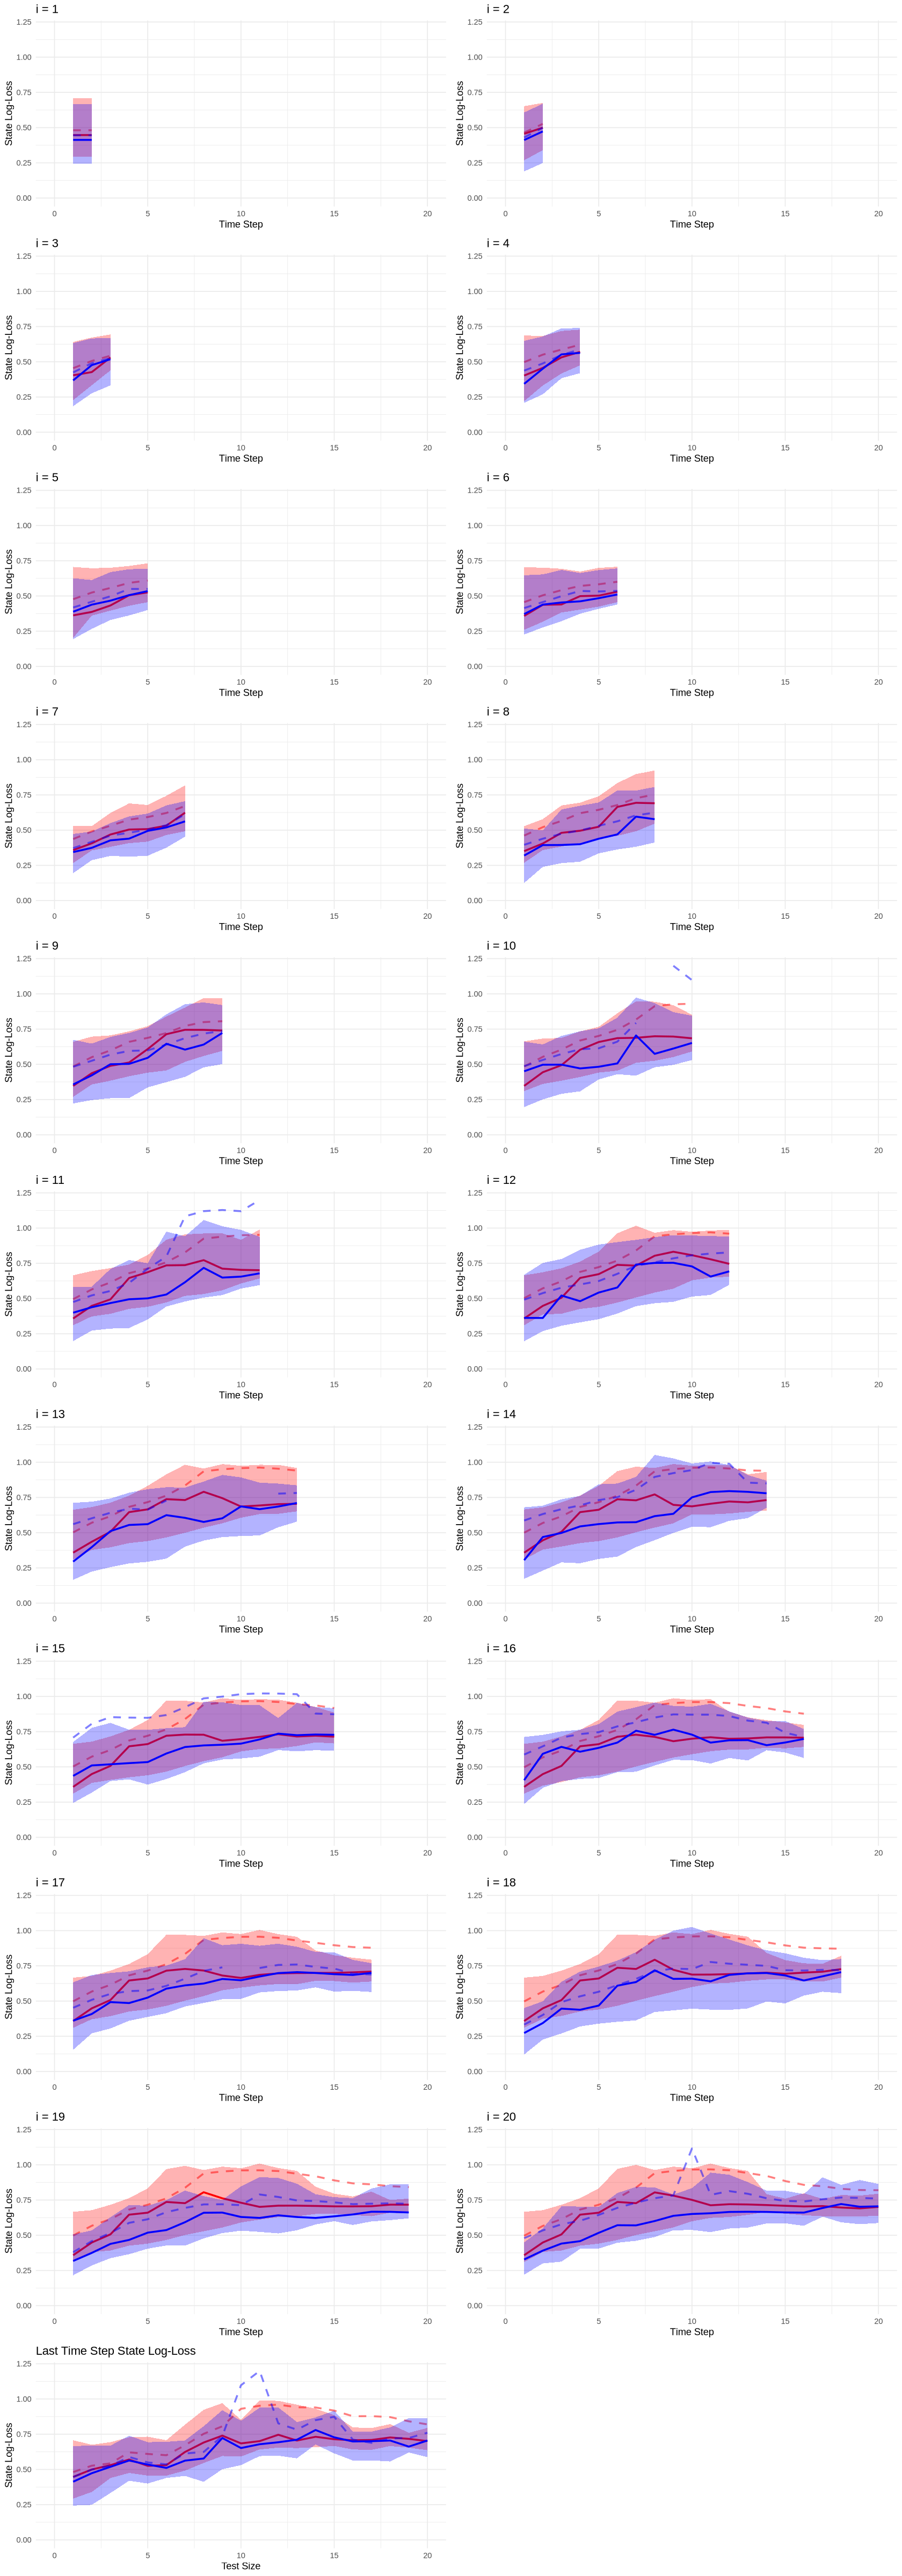

In [11]:
plot_loss <- function(results, type = "state_logloss") {
  safe_rowMeans <- function(x) {
    if (is.null(dim(x))) return(rep(mean(x, na.rm = TRUE), 2))
    rowMeans(x, na.rm = TRUE)
  }
  safe_rowPercentile <- function(x, p) {
    if (is.null(dim(x))) return(rep(quantile(x, probs = p, na.rm = TRUE)[[1]], 2))
    apply(x, 1, quantile, probs = p, na.rm = TRUE)
  }
  average_accross_series <- function(results, model, type) {
    logloss <- sapply(results, function(series)
      sapply(series, function(x) {
        x[[model]][[type]]
      })
    )
    logloss_mean <- sapply(logloss, safe_rowMeans)
    logloss_25th <- sapply(logloss, function(x)
      safe_rowPercentile(x, 0.25)
    )
    logloss_75th <- sapply(logloss, function(x)
      safe_rowPercentile(x, 0.75)
    )
    logloss_50th <- sapply(logloss, function(x)
      safe_rowPercentile(x, 0.50)
    )
    list(
      mean   = logloss_mean,
      p25    = logloss_25th,
      p75    = logloss_75th,
      median = logloss_50th
    )
  }
  cov_loss <- average_accross_series(results, "cov_model", type)
  tsx_loss <- average_accross_series(results, "tsx_model", type)

  last_row_plot_data <- data.frame(
      x = 1:length(results),
      median = sapply(tsx_loss$median, tail, 1),
      lower = sapply(tsx_loss$p25, tail, 1),
      upper = sapply(tsx_loss$p75, tail, 1),
      mean = sapply(tsx_loss$mean, tail, 1),
      cov_median = sapply(cov_loss$median, tail, 1),
      cov_lower = sapply(cov_loss$p25, tail, 1),
      cov_upper = sapply(cov_loss$p75, tail, 1),
      cov_mean = sapply(cov_loss$mean, tail, 1)
    )
  combined_plot <-
    ggplot(last_row_plot_data, aes(x = x)) +
      geom_ribbon(aes(ymin = lower, ymax = upper), fill = "red", alpha = 0.3) +
      geom_line(aes(y = median), color = "red", linewidth = 1) +
      geom_line(aes(y = mean), color = "red", linetype = "dashed", linewidth = 1, alpha = 0.5) +
      geom_ribbon(aes(ymin = cov_lower, ymax = cov_upper), fill = "blue", alpha = 0.3) +
      geom_line(aes(y = cov_median), color = "blue", linewidth = 1) +
      geom_line(aes(y = cov_mean), color = "blue", linetype = "dashed", linewidth = 1, alpha = 0.5) +
      labs(x = "Test Size", y = "State Log-Loss", title = "Last Time Step State Log-Loss") +
      theme_minimal() +
      {if (type == "state_logloss") ylim(0, 1.2)} +
      xlim(0, 20)
  
  plot_list <- lapply(1:length(results), function(i) {
    plot_data <- data.frame(
      x = 1:length(tsx_loss$median[[i]]),
      median = tsx_loss$median[[i]],
      lower = tsx_loss$p25[[i]],
      upper = tsx_loss$p75[[i]],
      mean = tsx_loss$mean[[i]],
      cov_median = cov_loss$median[[i]],
      cov_lower = cov_loss$p25[[i]],
      cov_upper = cov_loss$p75[[i]],
      cov_mean = cov_loss$mean[[i]]
    )
  
  ggplot(plot_data, aes(x = x)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), fill = "red", alpha = 0.3) +
    geom_line(aes(y = median), color = "red", linewidth = 1) +
    geom_line(aes(y = mean), color = "red", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = cov_lower, ymax = cov_upper), fill = "blue", alpha = 0.3) +
    geom_line(aes(y = cov_median), color = "blue", linewidth = 1) +
    geom_line(aes(y = cov_mean), color = "blue", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    labs(x = "Time Step", y = "State Log-Loss", title = paste("i =", i)) +
    {if (type == "state_logloss") ylim(0, 1.2)} +
    xlim(0, 20) +
    theme_minimal()
  })
  plot_list[[length(results) + 1]] <- combined_plot
  options(repr.plot.width = 14, repr.plot.height = 40)
  grid.arrange(grobs = plot_list, ncol = 2)
}

plot_loss(results, type = "state_logloss")

## Plot samples of individual trials

In [16]:
results[[3]][[2]]$cov_model

$state_forecast
          [,1]       [,2]         [,3]
[1,] 0.9883859 0.01161405 3.068319e-13
[2,] 0.9611159 0.03828416 5.998981e-04
[3,] 0.8369036 0.15744909 5.647333e-03

$true_states
          state1      state2       state3
[660,] 0.9977465 0.002253455 1.494443e-15
[661,] 0.9946662 0.005333289 5.391639e-07
[662,] 0.9787624 0.021237622 9.077859e-11

$state_logloss
             [,1]
[660,] 0.02169606
[661,] 0.05685371
[662,] 0.21352614

$prediction_logloss
[1] -1.4507371 -1.2995069 -0.6873918

$hmm
#######################
## Observation model ##
#######################
+ TSX_Composite ~ norm(mean, sd) 
  * mean.state1 ~ 1
  * mean.state2 ~ 1
  * mean.state3 ~ 1
  * sd.state1 ~ 1
  * sd.state2 ~ 1
  * sd.state3 ~ 1
 
> Initial observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.030  -0.001   0.003
TSX_Composite.sd     0.062   0.020   0.008

#########################
## State process model ##
#########################
                      

In [17]:
results[[3]][[2]]$tsx_model

$state_forecast
          [,1]       [,2]         [,3]
[1,] 0.9671730 0.03282702 7.364363e-09
[2,] 0.9354848 0.06305176 1.463415e-03
[3,] 0.9049005 0.09088905 4.210435e-03

$true_states
          state1      state2       state3
[660,] 0.9964174 0.003582557 1.114706e-11
[661,] 0.9942105 0.005789381 1.294975e-07
[662,] 0.9916313 0.008368679 3.330110e-11

$state_logloss
             [,1]
[660,] 0.04549817
[661,] 0.08230578
[662,] 0.11916305

$prediction_logloss
[1] -1.6142093 -1.4395132 -0.8771916

$hmm
#######################
## Observation model ##
#######################
+ TSX_Composite ~ norm(mean, sd) 
  * mean.state1 ~ 1
  * mean.state2 ~ 1
  * mean.state3 ~ 1
  * sd.state1 ~ 1
  * sd.state2 ~ 1
  * sd.state3 ~ 1
 
> Initial observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.021  -0.001   0.003
TSX_Composite.sd     0.056   0.019   0.008

#########################
## State process model ##
#########################
        state 1 state 

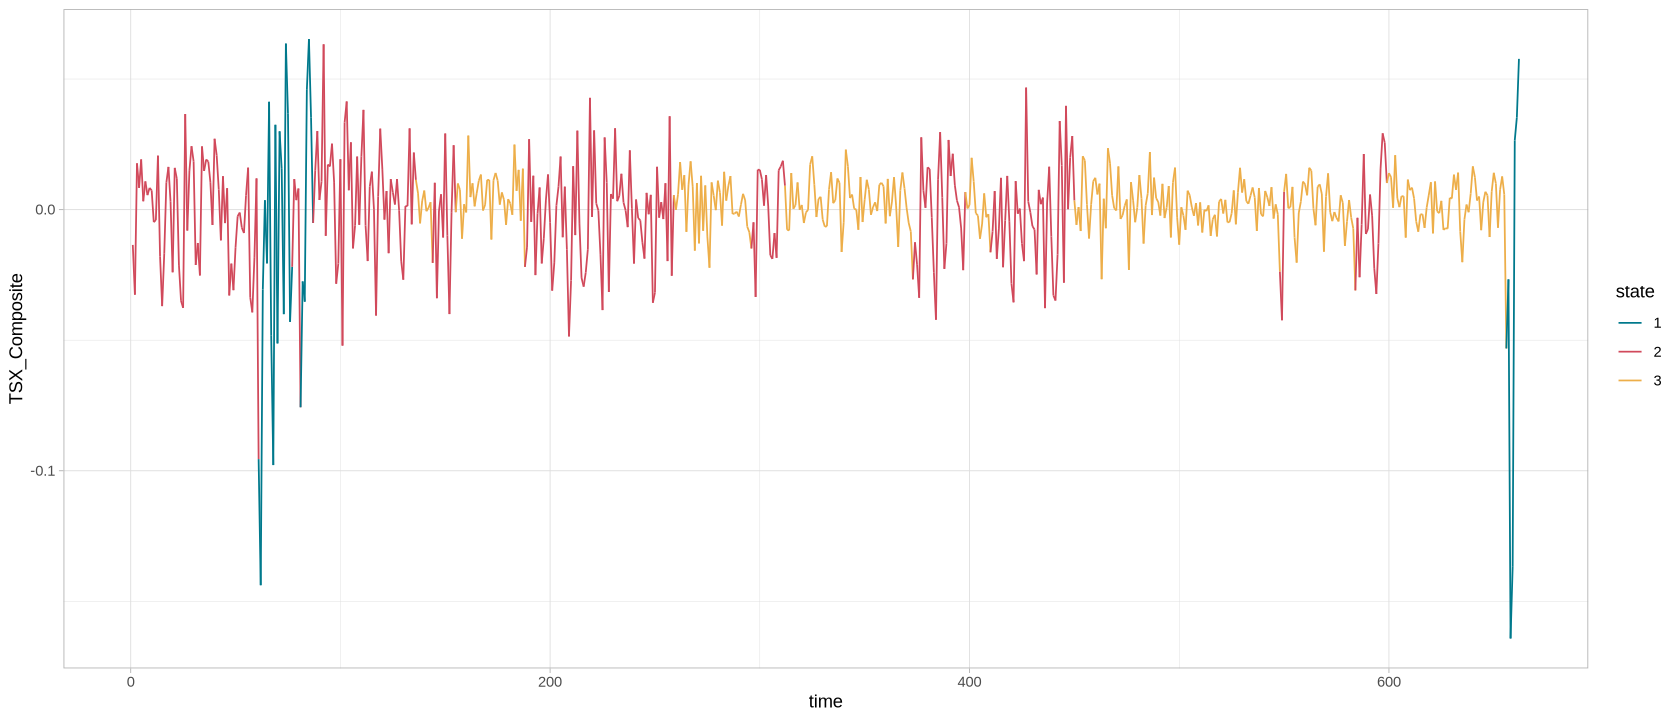

In [14]:
options(repr.plot.width = 14, repr.plot.height = 6)
results[[3]][[2]]$cov_model$hmm$plot_ts("TSX_Composite")

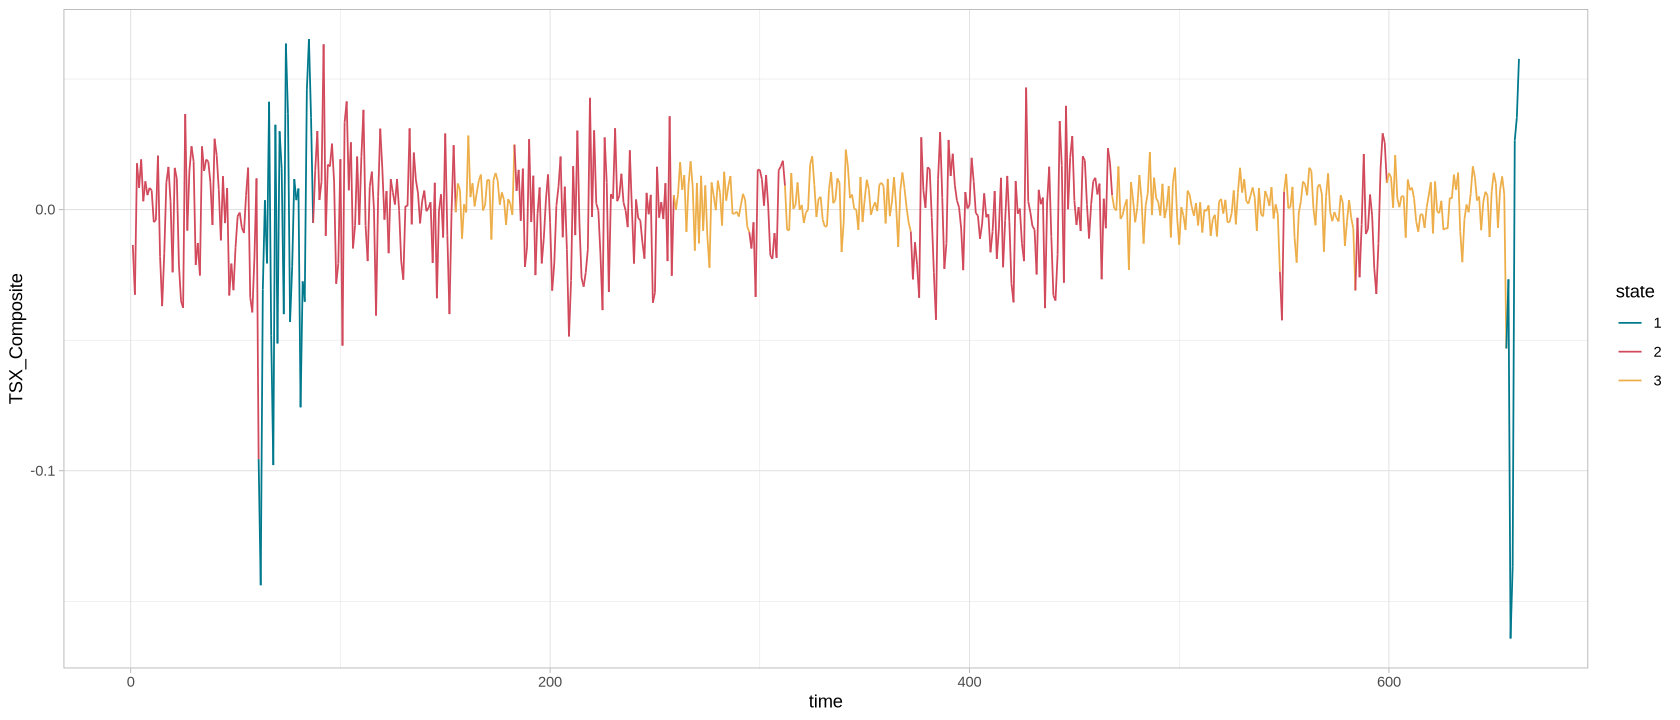

In [15]:
results[[3]][[2]]$tsx_model$hmm$plot_ts("TSX_Composite")